In [43]:
import gurobipy as gp

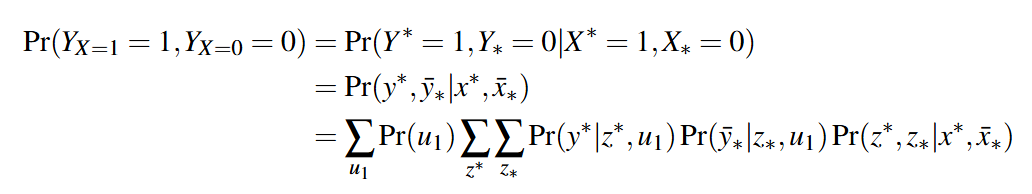

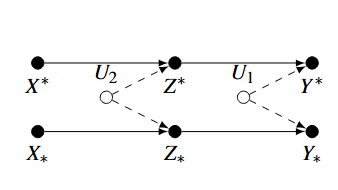

In [44]:
#           000   001  010  011   100   101  110  111
u1_probs = [0.05, 0.1, 0.2, 0.10, 0.15, 0.1, 0.2, 0.1]
#           00    01   10   11
u2_probs = [0.1, 0.2, 0.4, 0.3]

mecanismos_u2 = ["0", "x", "not_x", "1"]
mecanismos_u1 = ["0", "z", "not_z", "1", "0", "z", "not_z", "1"]

n_u1_vars = 8
n_u2_vars = 4

def get_z_value(j_u2, x, mecanismos_u2):
    if mecanismos_u2[j_u2] == "x":
        return x
    elif mecanismos_u2[j_u2] == "not_x":
        return int(not x)
    return int(mecanismos_u2[j_u2])

def get_y_value(k_u1, z, mecanismos_u1):
    if mecanismos_u1[k_u1] == "z":
        return z
    elif mecanismos_u1[k_u1] == "not_z":
        return int(not z)
    return int(mecanismos_u1[k_u1])

Z_given_X = [[0, 0], [0, 0]]
for z in range(2):
    for x in range(2):
        for j in range(n_u2_vars):
            got_z = get_z_value(j, x, mecanismos_u2)
            Z_given_X[z][x] += u2_probs[j] if z == got_z else 0
        Z_given_X[z][x] = round(Z_given_X[z][x], 3)
        print(f"P(Z={z} | X={x}) = {Z_given_X[z][x]}")

Y_given_Z = [[0,0], [0,0]]
for y in range(2):
    for z in range(2):
        for k in range(n_u1_vars):
            got_y = get_y_value(k, z, mecanismos_u1)
            Y_given_Z[y][z] += u1_probs[k] if y == got_y else 0
        Y_given_Z[y][z] = round(Y_given_Z[y][z], 3)
        print(f"P(Y={y} | Z={z}) = {Y_given_Z[y][z]}")


X_0 = 0
for k in range(4):
    '''
    000
    001
    010
    011
    '''
    X_0 += u1_probs[k]
X_0 = round(X_0, 3)
print(f"P(X=0) = {X_0}")

P(Z=0 | X=0) = 0.3
P(Z=0 | X=1) = 0.5
P(Z=1 | X=0) = 0.7
P(Z=1 | X=1) = 0.5
P(Y=0 | Z=0) = 0.4
P(Y=0 | Z=1) = 0.6
P(Y=1 | Z=0) = 0.6
P(Y=1 | Z=1) = 0.4
P(X=0) = 0.45


In [45]:
model = gp.Model("bilinear")

vars = model.addVars(n_u1_vars + n_u2_vars, obj=1, name="Variables")

objective_function = 0
x_star = 1
y_star = 1
x_low_star = 0
y_low_star = 0

deb_expr = "Objective Function = "
for k in range(n_u1_vars):
    for j in range(n_u1_vars, n_u1_vars + n_u2_vars):
        for z_star in range(2):
            for z_low_star in range(2):
                z = get_z_value(j-n_u1_vars, x_star, mecanismos_u2)
                p_z_star_given_x_star_u2 = 1 if z == z_star else 0
                y = get_y_value(k, z_star, mecanismos_u1)
                p_y_star_given_z_star_u1 = 1 if y == y_star else 0
                
                z = get_z_value(j-n_u1_vars, x_low_star, mecanismos_u2)
                p_z_low_star_given_x_star_u2 = 1 if z == z_low_star else 0
                y = get_y_value(k, z_low_star, mecanismos_u1)
                p_y_low_star_given_z_star_u1 = 1 if y == y_low_star else 0
                
                coef = p_z_star_given_x_star_u2 * p_y_star_given_z_star_u1 * p_z_low_star_given_x_star_u2 * p_y_low_star_given_z_star_u1
                if coef == 0:
                    continue
                deb_expr += f"({coef} * u1_{k} * u2_{j-n_u1_vars}) + "
                objective_function += coef * vars[k] * vars[j]
print(deb_expr[:len(deb_expr)-2])
model.setObjective(objective_function)

print("-----------")
print("Constraints:")

z = 1
for x in range(2):
    deb_expr = f"P(Z={z} | X={x}) = "
    constr_expression = 0
    for j in range(n_u2_vars):
        got_z = get_z_value(j, x, mecanismos_u2)
        if z != got_z:
            continue
        constr_expression += vars[j+n_u1_vars] 
        deb_expr += f"u2_{j} + "
    deb_expr = deb_expr[:len(deb_expr)-2]
    deb_expr += f"= {Z_given_X[z][x]}"
    print(f"{deb_expr}")
    model.addConstr(constr_expression == Z_given_X[z][x])

constr_expression = 0
deb_expr = f"P(U2) = "
for j in range(n_u2_vars):
    constr_expression += vars[j+n_u1_vars]
    deb_expr += f"u2_{j} + "
deb_expr = deb_expr[:len(deb_expr)-2]
deb_expr += f"= 1.0"
print(f"{deb_expr}")
model.addConstr(constr_expression == 1.0)

print("-----------")

y = 1
for z in range(2):
    deb_expr = f"P(Y={y} | Z={z}) = "
    constr_expression = 0
    for k in range(n_u1_vars):
        got_y = get_y_value(k, z, mecanismos_u1)
        if y != got_y:
            continue
        constr_expression += vars[k]
        deb_expr += f"u1_{k} + "
    deb_expr = deb_expr[:len(deb_expr)-2]
    deb_expr += f"= {Y_given_Z[y][z]}"
    print(f"{deb_expr}")
    model.addConstr(constr_expression == Y_given_Z[y][z])

constr_expression = 0
deb_expr = f"P(U1) = "
for k in range(n_u1_vars):
    constr_expression += vars[k]
    deb_expr += f"u1_{k} + "
deb_expr = deb_expr[:len(deb_expr)-2]
deb_expr += f"= 1.0"
print(f"{deb_expr}")
model.addConstr(constr_expression == 1.0)

constr_expression = 0
deb_expr = f"P(X=0) = "
for k in range(4):
    constr_expression += vars[k]
    deb_expr += f"u1_{k} + "
model.addConstr(constr_expression == X_0)
deb_expr = deb_expr[:len(deb_expr)-2]
deb_expr += f"= {X_0}"
print(f"{deb_expr}")


Objective Function = (1 * u1_1 * u2_1) + (1 * u1_2 * u2_2) + (1 * u1_5 * u2_1) + (1 * u1_6 * u2_2) 
-----------
Constraints:
P(Z=1 | X=0) = u2_2 + u2_3 = 0.7
P(Z=1 | X=1) = u2_1 + u2_3 = 0.5
P(U2) = u2_0 + u2_1 + u2_2 + u2_3 = 1.0
-----------
P(Y=1 | Z=0) = u1_2 + u1_3 + u1_6 + u1_7 = 0.6
P(Y=1 | Z=1) = u1_1 + u1_3 + u1_5 + u1_7 = 0.4
P(U1) = u1_0 + u1_1 + u1_2 + u1_3 + u1_4 + u1_5 + u1_6 + u1_7 = 1.0
P(X=0) = u1_0 + u1_1 + u1_2 + u1_3 = 0.45


In [49]:
model.params.outputFlag = 0
model.modelSense = gp.GRB.MINIMIZE
model.optimize()
if model.Status == gp.GRB.OPTIMAL: # OPTIMAL
        lower = model.objVal
        print(f"Minimal solution found! MIN Query: {lower}")
else:
    print(f"Minimal solution not found. Gurobi status code: {model.Status}")
    lower = None


model.modelSense = gp.GRB.MAXIMIZE
model.optimize()
if model.Status == gp.GRB.OPTIMAL: # OPTIMAL
        upper = model.objVal
        print(f"Maximal solution found! MAX Query: {upper}")
else:
    print(f"Maximal solution not found. Gurobi status code: {model.Status}")
    upper = None
print(f"Query interval = [{lower, upper}]")

Minimal solution found! MIN Query: 0.04000000661638091
Maximal solution found! MAX Query: 0.4199999900972092
Query interval = [(0.04000000661638091, 0.4199999900972092)]


In [47]:
model = gp.Model("linear")

U1_vars = list[]

for u1 in U1_vars:
    for z0 in range(2):
        for z1 in range(2):
            # Mecha? Prob (y* | z* u1)
            # Mecha? Prob (hat y_* | z_* u1)
            # Empirical Prob (z* , z_* | x*, hat x_*)
            pass

number_of_vars_1 = len(decisionMatrix_1[0])
number_of_vars_2 = len(decisionMatrix_2[0])

vars = model.addVars(number_of_vars_1 + number_of_vars_2, obj=1, name="Variables")

constrs_1 = model.addConstrs(
    (gp.quicksum(decisionMatrix_1[i][j] * vars[j] for j in range(number_of_vars_1)) == probs_1[i]
    for i in range(len(probs_1))),
    name="Intervention_1_Related_Constraints"
)

constrs_2 = model.addConstrs(
    (gp.quicksum(decisionMatrix_2[i][j] * vars[j + number_of_vars_1] for j in range(number_of_vars_2)) == probs_2[i]
    for i in range(len(probs_2))),
    name="Intervention_2_Related_Constraints"
)

model.setObjective(
    gp.quicksum(objFunctionCoefficients[i][j] * vars[i] * vars[j] for i in range(number_of_vars_1) for j in range(number_of_vars_2)),
)

model.params.outputFlag = 0

model.modelSense = gp.GRB.MINIMIZE
model.optimize()
duals_1 = model.getAttr("pi", constrs_1)
duals_2 = model.getAttr("pi", constrs_2)
print(f"duals: {duals_1}, {duals_2}")
if model.Status == gp.GRB.OPTIMAL: # OPTIMAL
        lower = model.objVal
        print(f"Minimal solution found! -- MIN Query: {lower}")
else:
    print(f"Minimal solution not found. Gurobi status code: {model.Status}")
    lower = None


model.modelSense = gp.GRB.MAXIMIZE
model.optimize()
duals_1 = model.getAttr("pi", constrs_1)
duals_2 = model.getAttr("pi", constrs_2)
print(f"duals: {duals_1}, {duals_2}")
if model.Status == gp.GRB.OPTIMAL: # OPTIMAL
        upper = model.objVal
        print(f"Maximal solution found! -- MAX Query: {upper}")
else:
    print(f"Maximal solution not found. Gurobi status code: {model.Status}")
    upper = None

print(f"Query interval = [{lower, upper}]")


SyntaxError: invalid syntax (2843654511.py, line 3)